# Spectral Normalized Gaussian Process (SNGP) Classification

In [49]:
import os
import tempfile

import torch
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.uq_methods import SNGPClassification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_training_metrics,
    plot_two_moons_data,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
seed_everything(2)
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

Seed set to 2


## Datamodule

In [39]:
dm = TwoMoonsDataModule(batch_size=128)

In [40]:
# define data
X_train, y_train, X_test, y_test, test_grid_points = (
    dm.X_train,
    dm.y_train,
    dm.X_test,
    dm.y_test,
    dm.test_grid_points,
)

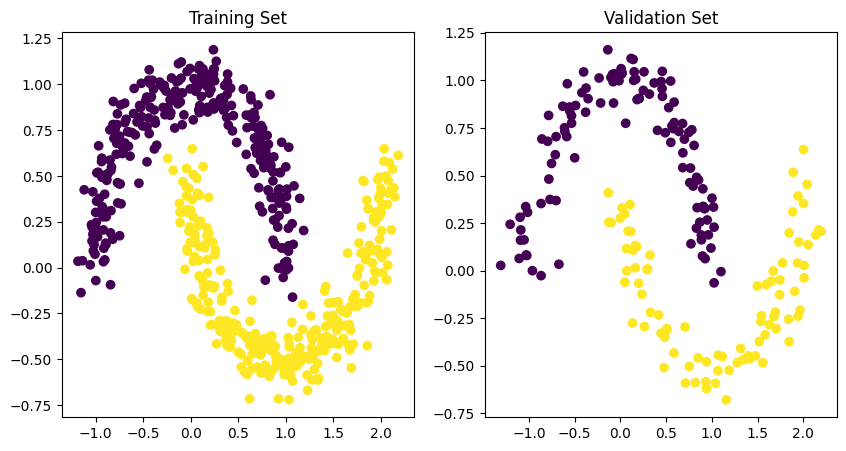

In [41]:
fig = plot_two_moons_data(X_train, y_train, X_test, y_test)

## Model

In [42]:
feature_extractor = FCResNet(input_dim=2, features=64, depth=4)

In [43]:
sngp = SNGPClassification(
    feature_extractor=feature_extractor,
    loss_fn=torch.nn.CrossEntropyLoss(),
    num_targets=2,
)

## Trainer

In [44]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
trainer.fit(sngp, dm)

Missing logger folder: /tmp/tmpamr83u0s/lightning_logs

  | Name              | Type                  | Params
------------------------------------------------------------
0 | feature_extractor | FCResNet              | 16.8 K
1 | loss_fn           | CrossEntropyLoss      | 0     
2 | normalize         | LayerNorm             | 256   
3 | rff               | RandomFourierFeatures | 0     
4 | beta              | Linear                | 2.0 K 
5 | train_metrics     | MetricCollection      | 0     
6 | val_metrics       | MetricCollection      | 0     
7 | test_metrics      | MetricCollection      | 0     
------------------------------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.077     Total estimated model params size (MB)


/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=100` reached.


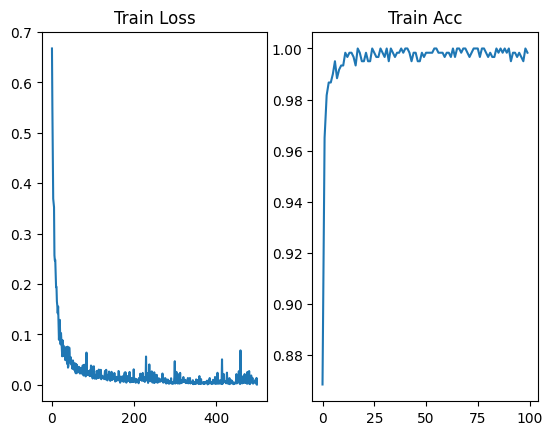

In [46]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "Acc")

In [47]:
preds = sngp.predict_step(test_grid_points)

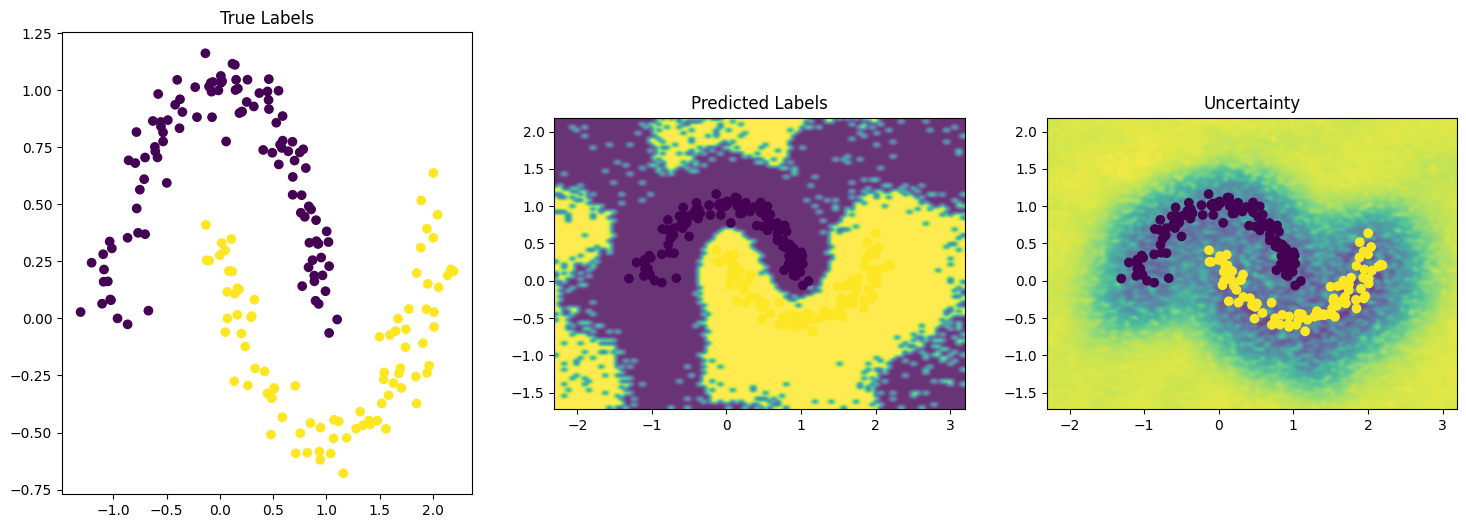

In [50]:
fig = plot_predictions_classification(
    X_test,
    y_test,
    preds["pred"].argmax(-1),
    test_grid_points,
    preds["pred_uct"].cpu().numpy(),
)